## Imports

In [1]:
import fastai
from fastai.vision.all import *
#from hyperdash import monitor_cell, Experiment
import PIL

## Establishing CUDA device

In [2]:
# checking device number
assert torch.cuda.is_available()
index_device = torch.cuda.current_device()

## Read Data

In [3]:
#"/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/"
data_path = "/u/scratch/s/stecproj/image_data/image_based/hawaii/"

In [12]:
dls = ImageDataLoaders.from_folder(
    data_path, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=256, #512, changed to 256 since my(Hamlin) GPU ran out of memory
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

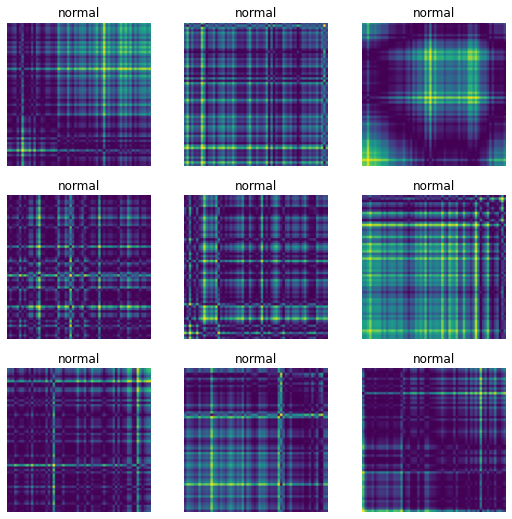

In [13]:
dls.show_batch()

In [14]:
dls.dataset

(#19246) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...]

In [15]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [16]:
# define the learner 
learn = cnn_learner(
    dls, # data
    squeezenet1_1, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

In [17]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

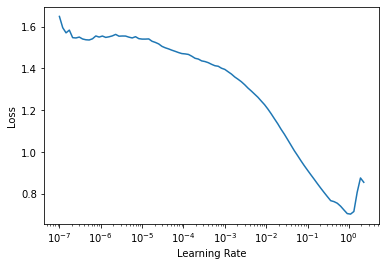

In [18]:
# find the minimum learning rate 
lr_min, lr_steep = learn.lr_find()

In [19]:
lr_min 

0.10964782238006592

In [20]:
lr = lr_min * 0.01
lr

0.0010964782238006591

In [21]:
# parallel GPUs!
# parallel_gpus = False
if torch.cuda.device_count() > 1:
    # parallel_gpus = True
    learn.model = nn.DataParallel(learn.model)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.491772,0.041758,0.003326,0.996674,00:17
1,0.173312,0.020841,0.003326,0.996674,00:14
2,0.070523,0.023770,0.003326,0.996674,00:14
3,0.041218,0.025563,0.003326,0.996674,00:14
4,0.033082,0.021929,0.003326,0.996674,00:14
5,0.030783,0.021983,0.003326,0.996674,00:14
6,0.028922,0.021919,0.003326,0.996674,00:14


Better model found at epoch 0 with valid_loss value: 0.04175844416022301.


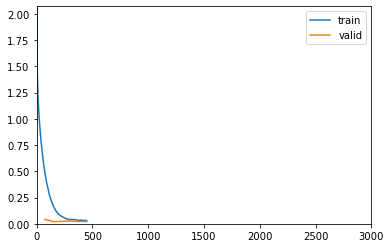

Better model found at epoch 1 with valid_loss value: 0.020841481164097786.
Epoch 3: reducing lr to 0.00010964782238006592
Epoch 5: reducing lr to 1.0964782238006591e-05
No improvement since epoch 1: early stopping


0.9966742880897942


In [22]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# Create an experiment with a model name, then autostart
#exp = Experiment("Tsunami-related sTEC d/dt Anomaly Detection")

# set the parameters 
# model = exp.param("model", squeezenet1_1)
# lr = exp.param("learning_rate", lr)
# device_name = exp.param("device_name", torch.cuda.get_device_name(index_device))
# parallel_gpus = exp.param("parallel GPU", parallel_gpus)
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 


# train the model 
learn.fit(
    40, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=2
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=5,
            min_delta=0.0005
        ),
        SaveModelCallback()
    ]
) 

# interpret results from test set
interp = ClassificationInterpretation.from_learner(learn) 
cm = interp.confusion_matrix()
accuracy = np.trace(cm)/np.sum(cm)
total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
precision = cm[0, 0] / total_anon
recall = cm[0, 0] / pred_anon
denom = (precision + recall) if (precision + recall) > 0 else 1
F1 = 2 * precision * recall / denom

print(accuracy)
# need to do the following for training sets

# TODO: accuracy = exp.metric("accuracy", classifer.score(X_test, y_test))
# TODO: recall 
# TODO: precision 
# TODO: F-score 
# TODO: coverage for both holdout and training
# DONE: holdout recall, precision, accuracy, f-score,  as well 
# TODO: total training time 
# TODO: train loss, valid loss, error rate 

# end the experiment 
# TODO: in future move experiment end to include additional validation, experimentation 
# exp.end()

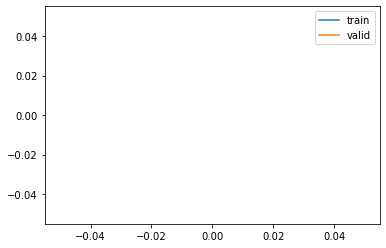

In [23]:
# plot the loss curve from model training
learn.recorder.plot_loss()

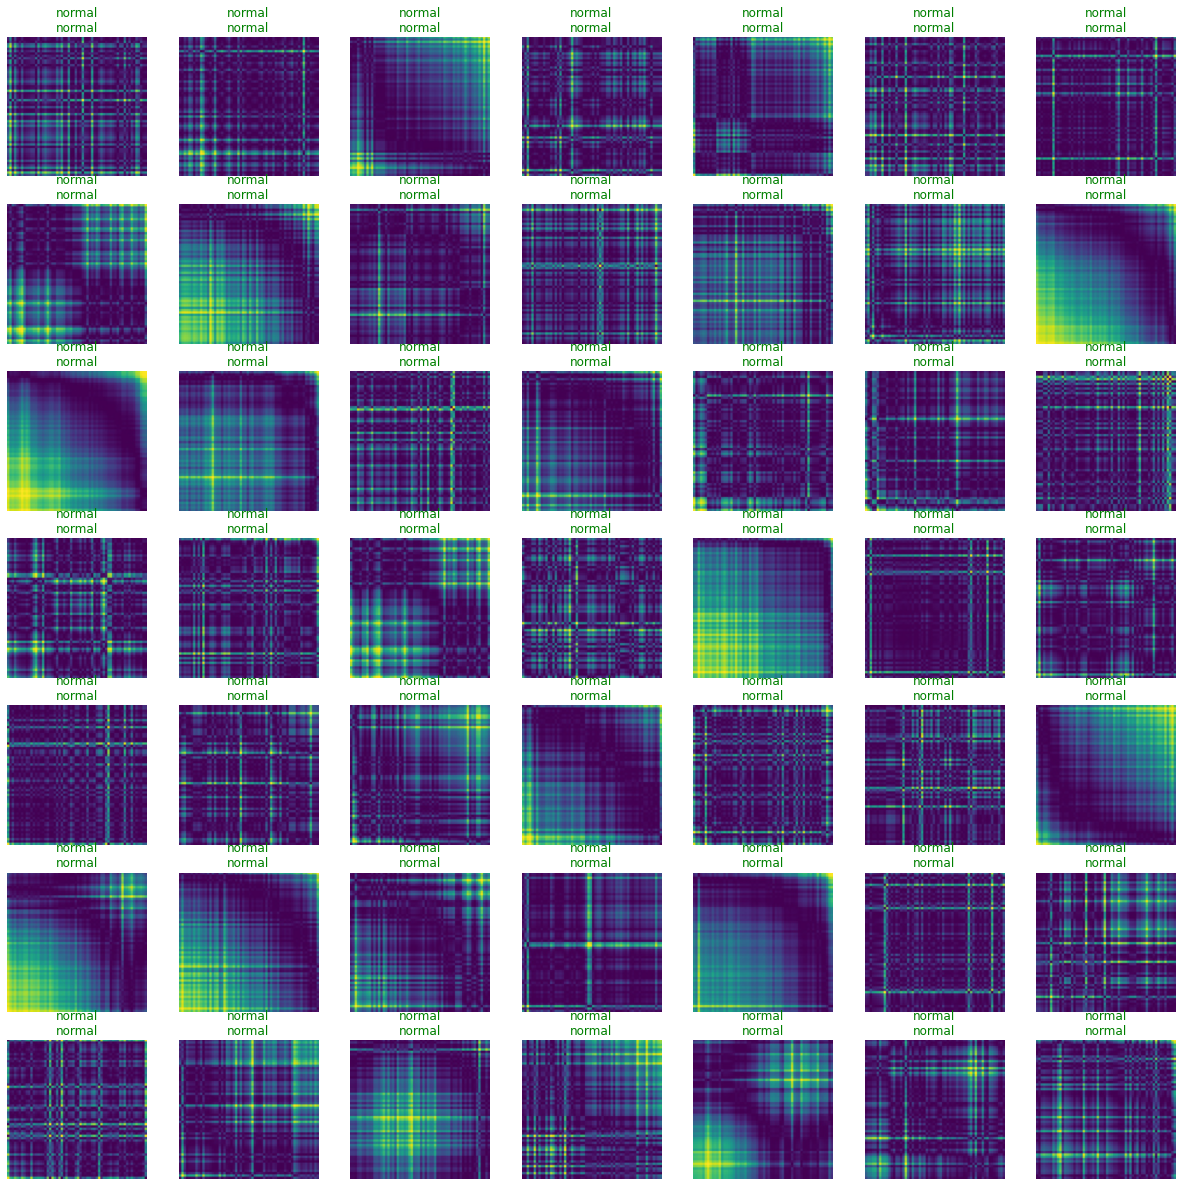

In [24]:
learn.show_results(max_n=49)

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

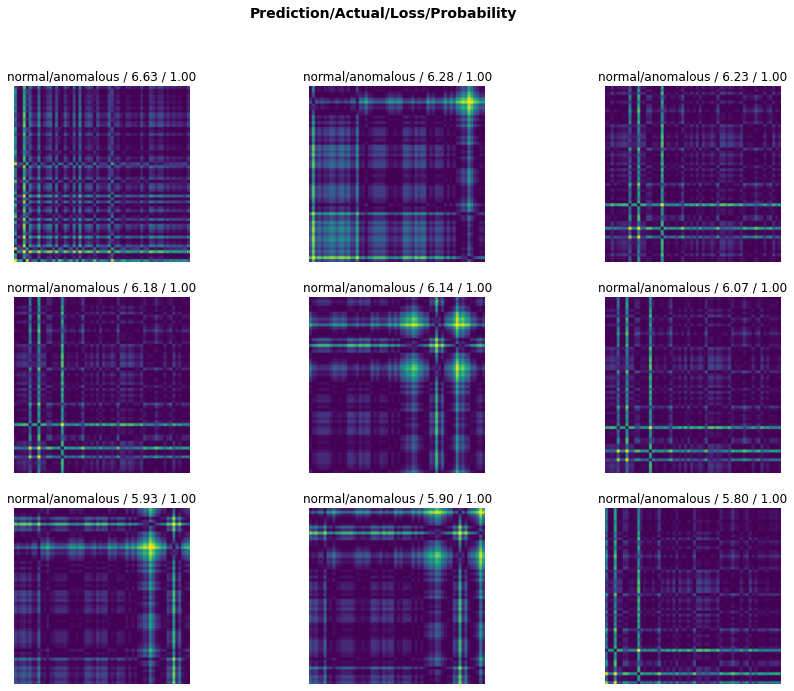

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

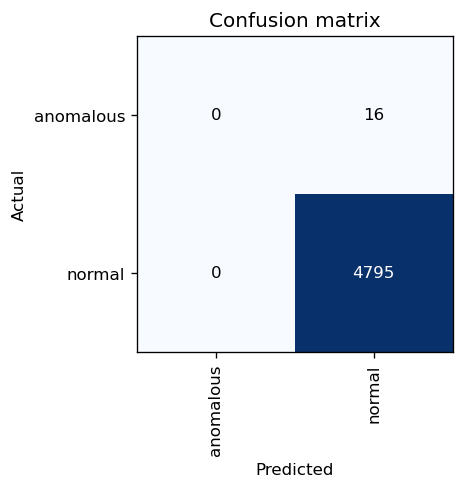

In [27]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [69]:
# TODO: from confusion matrix, generate anomalous and normal recall, precision, F-Scores. 

# SCRATCH work
### To be deleted when requesting merge

In [78]:
# clear cache and variables 
a = learn.get_preds()


In [83]:
len(a[1])


4811

In [125]:
learn.metrics[1].__dict__

{'func': <function fastai.metrics.accuracy(inp, targ, axis=-1)>,
 'total': TensorBase(4796.),
 'count': 4811}

In [22]:
dl = learn.dls[1]

In [23]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [24]:
arr

(TensorImage([[[[0.2627, 0.2667, 0.2745,  ..., 0.2745, 0.2706, 0.2667],
           [0.2667, 0.2667, 0.2745,  ..., 0.2824, 0.2784, 0.2784],
           [0.2745, 0.2745, 0.2784,  ..., 0.2784, 0.2745, 0.2706],
           ...,
           [0.2392, 0.2314, 0.2588,  ..., 0.2706, 0.2706, 0.2706],
           [0.2235, 0.2157, 0.2392,  ..., 0.2627, 0.2706, 0.2745],
           [0.2392, 0.2235, 0.2392,  ..., 0.2706, 0.2784, 0.2784]],
 
          [[0.0235, 0.0196, 0.0157,  ..., 0.0824, 0.0863, 0.0824],
           [0.0235, 0.0235, 0.0196,  ..., 0.0784, 0.0824, 0.0824],
           [0.0196, 0.0196, 0.0157,  ..., 0.0784, 0.0824, 0.0824],
           ...,
           [0.2980, 0.3059, 0.2902,  ..., 0.0196, 0.0157, 0.0157],
           [0.3137, 0.3176, 0.3020,  ..., 0.0235, 0.0196, 0.0235],
           [0.3020, 0.3059, 0.3020,  ..., 0.0235, 0.0157, 0.0157]],
 
          [[0.3608, 0.3569, 0.3569,  ..., 0.4039, 0.4039, 0.4039],
           [0.3569, 0.3529, 0.3529,  ..., 0.4039, 0.4078, 0.4039],
           [0.3451,

In [18]:
z = interp.confusion_matrix()

In [124]:
np.trace(z)/np.sum(z)

0.996882145084182

In [126]:
np.sum(z[:, 0])

0

In [130]:
learn.dls.loaders[1]

In [131]:
dl

In [19]:
cm = interp.confusion_matrix()
accuracy = np.trace(cm)/np.sum(cm)
total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
precision = cm[0, 0] / total_anon
recall = cm[0, 0] / pred_anon
denom = (precision + recall) if (precision + recall) > 0 else 1
F1 = 2 * precision * recall / denom

In [20]:
F1

0.0

In [21]:
cm

array([[   0,   11],
       [   0, 4800]])

In [26]:
dl = learn.dls[0]


In [28]:
vars(dl)

{'after_item': Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor,
 'before_batch': Pipeline: ,
 'after_batch': Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1},
 '__stored_args__': {'dataset': (#19246) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...],
  'bs': 256,
  'shuffle': True,
  'drop_last': True,
  'indexed': True,
  'n': 19246,
  'pin_memory': False,
  'timeout': 0,
  'device': device(type='cuda', index=0)},
 'dataset': (#1

In [29]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

IndexError: index 19203 is out of bounds for dimension 0 with size 19200

In [5]:
print(normal[4460])
len(normal)


/u/scratch/s/stecproj/image_data/image_based/hawaii/pat2__G08/labeled/normal/302_74_134_GAF.jpg


5101

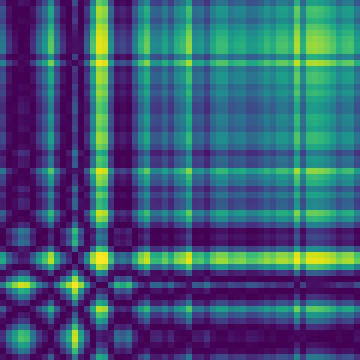

In [6]:
PIL.Image.open(anomalies[29])
PIL.Image.open(anomalies[29])
PIL.Image.open(normal[4460])

In [4]:
anomalies = get_image_files(data_path + "pat2__G08/labeled/anomalous/")
normal = get_image_files(data_path + "pat2__G08/labeled/normal/")